In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
rng = "Sobol"
# rng = "Race"

in_feature = 512
out_feature = 10000

mode = "bipolar"
scaled = False
bias =   True

bitwidth = 8
length = 2**bitwidth

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
print(fc.weight.data.shape)

if mode == "unipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
elif mode == "bipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                  bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias).to(device)
# gMUL + gADD
# ufc = GainesLinear1(in_feature, out_feature, fc.weight, fc.bias, 
#                     bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias, depth=bitwidth, rng_idx=2).to(device)
# gMUL + uADD
# ufc = GainesLinear2(in_feature, out_feature, fc.weight, fc.bias, 
#                     bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias, depth=bitwidth, rng_idx=2).to(device)
# uMUL + gADD
# ufc = GainesLinear3(in_feature, out_feature, fc.weight, fc.bias, 
#                     bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias, depth=bitwidth, rng_idx=2).to(device)

iVec = (((torch.rand(1, in_feature)*length).round()/length)/in_feature).to(device)
oVec = fc(iVec)

if scaled is False:
    oVec = oVec.clamp(-1.,1.).mul(length).floor()/length
else:
    if bias is True:
        oVec = oVec.div(in_feature+1).mul(length).floor()/length
    else:
        oVec = oVec.div(in_feature).mul(length).floor()/length

        
iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode)().to(device)

iVecRNG = RNG(bitwidth, 2, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range(256):
#         print(i)
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)
        
#         print(idx+i)
#         print(iBS)
        oVecU = ufc(iBS)
        oVecPE.Monitor(oVecU)
#         print("\n")
    print("--- %s seconds ---" % (time.time() - start_time))
    print("input error: ", min(min(iVecPE()[1])), max(max(iVecPE()[1])))
    print("output error:", min(min(oVecPE()[1])), max(max(oVecPE()[1])))
    print("output pp:", oVecPE()[0].data)
    result_pe = oVecPE()[1][0].cpu().numpy()
    print(torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature))
    print(result_pe)

torch.Size([10000, 512])
--- 0.12568449974060059 seconds ---
input error:  tensor(-0.0020, device='cuda:0') tensor(0., device='cuda:0')
output error: tensor(-0.4922, device='cuda:0') tensor(0.5039, device='cuda:0')
output pp: tensor([[ 0.5156, -0.0859, -0.5312,  ...,  0.5312, -0.5156, -0.3984]],
       device='cuda:0')
tensor(0.1814, device='cuda:0')
[-0.19921875 -0.0078125   0.25       ... -0.36328125  0.22265625
 -0.0078125 ]


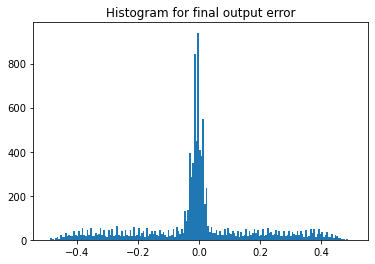

In [5]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [6]:
# passed test
# 1. unipolar,     scaled,     biased: passed
# 2. unipolar,     scaled, non-biased: passed
# 3. unipolar, non-scaled,     biased: passed
# 4. unipolar, non-scaled, non-biased: passed
# 5.  bipolar,     scaled,     biased: passed
# 6.  bipolar,     scaled, non-biased: passed
# 7.  bipolar, non-scaled,     biased: passed
# 8.  bipolar, non-scaled, non-biased: passed